# INFO 3401 – Class 26: Pointplots and heatmaps

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT).

## Learning Objectives
* Working with spatial point data in GeoPandas
* Visualizing spatial data as pointplots, sometimes in combination with choropleths
* Visualizing spatial point data as heatmaps and kdeplots

## Background

This module will explore how to acquire, analyze, and visualize spatial data. I have adapted this content from the excellent course [Auotmating GIS processes](https://automating-gis-processes.github.io/site/index.html) course by [Vuokko Heikinheimo](https://researchportal.helsinki.fi/en/persons/vuokko-vilhelmiina-heikinheimo) and [Henrikki Tenkanen](https://www.ucl.ac.uk/geospatial-analytics/people/henrikki-tenkanen).

## Load libraries

Load our usual libraries.

In [1]:
# Data processing libraries
import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

# Visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

# Geospatial libraries
import geopandas as gpd
from pyproj import CRS
import contextily, geoplot

import matplotlib.colors as colors

## Load data

We're going to use the National Highway Traffic Safety Administration's databases on fatal highway accidents. [Data going back to 1976 is available](https://www.nhtsa.gov/research-data/fatality-analysis-reporting-system-fars), but we'll focus on data since 2012. There's also a detailed [user manual](https://www.nhtsa.gov/filebrowser/download/176821) describing these columns if you're interested: the data we're using correspdong to the "ACCIDENT" data files. The Appendix section at the end of the notebook details how this data was generated.

In [2]:
fars_df = pd.read_csv('fars_2012-2018.csv')

print(fars_df.shape)

fars_df.head()

(226764, 55)


,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,NHS,ROAD_FNC,ROUTE,TWAY_ID,TWAY_ID2,MILEPT,LATITUDE,LONGITUD,SP_JUR,HARM_EV,MAN_COLL,RELJCT1,RELJCT2,TYP_INT,WRK_ZONE,REL_ROAD,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS,RAIL,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR,RUR_URB,FUNC_SYS,RD_OWNER,State Name,County Name
0,1,10001,1,1,0,0,0,2,2,81,0,1,1,2012,1,20,33,1,2.0,2,US-SR 38,NaN,987,32.701317,-85.525181,0,1,0,0,1,1,0,3,2,1,0,1,0,0000000,99,99,20,38,99,99,0,0,0,1,1,NaN,NaN,NaN,Alabama,Lee
1,1,10002,2,1,1,0,0,1,1,83,0,1,1,2012,1,13,15,0,16.0,4,CR-MAHALO CIRCLE,NaN,0,34.742508,-86.883506,0,14,0,0,1,1,0,7,1,1,0,1,0,0000000,99,99,13,45,99,99,0,0,0,1,0,NaN,NaN,NaN,Alabama,Limestone
2,1,10003,1,1,0,0,0,6,6,105,0,2,1,2012,2,1,35,1,2.0,3,SR-5,NaN,558,32.552053,-87.347769,0,35,0,0,1,1,0,4,2,1,0,1,0,0000000,99,99,2,25,99,99,0,0,0,1,0,NaN,NaN,NaN,Alabama,Perry
3,1,10004,2,2,0,0,0,5,5,81,2340,5,1,2012,5,15,12,1,11.0,1,I-85,NaN,620,32.641436,-85.354300,0,12,1,0,1,1,0,1,1,1,0,1,0,0000000,99,99,15,21,99,99,0,0,0,1,0,NaN,NaN,NaN,Alabama,Lee
4,1,10005,1,1,0,0,0,1,1,77,0,6,1,2012,6,6,0,0,5.0,4,CR-81,NaN,0,34.928028,-87.815056,0,42,0,0,1,1,0,4,4,1,0,1,0,0000000,99,99,8,0,88,88,0,0,0,1,0,NaN,NaN,NaN,Alabama,Lauderdale


Load the US shapefile too.

In [3]:
states_gdf = gpd.read_file('us_states/tl_2019_us_state.shp')

states_gdf.head(1)

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266231560,489271086,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."


Finally load the Colorado counties and convert the "county" name to title-case.

In [4]:
co_counties_gdf = gpd.read_file('co_counties/co_counties.shp')

co_counties_gdf['county'] = co_counties_gdf['county'].str.title()

co_counties_gdf.head(1)

,co_fips,county,househo_20,pop_2010,shape_st_1,shape_st_2,shape_star,shape_stle,geometry
0,1.0,Adams,154502.0,441603.0,3.064413e+09,392729.110497,0.0,0.0,"POLYGON ((-103.70574 39.99991, -103.70569 39.9..."


## Feature engineering

We need to convert some of the columns in this data into more useful data types.

First, take the "YEAR", "MONTH", "DAY", "HOUR", and "MINUTE" columns and use `pd.to_datetime` to combine them into a "Timestamp" column.

In [5]:
fars_df['Timestamp'] = pd.to_datetime(fars_df[['YEAR','MONTH','DAY','HOUR','MINUTE']])

fars_df['Timestamp'].head()

0   2012-01-01 20:33:00
1   2012-01-01 13:15:00
2   2012-01-02 01:35:00
3   2012-01-05 15:12:00
4   2012-01-06 06:00:00
Name: Timestamp, dtype: datetime64[ns]

Second, there are columns for "LATITUDE" (y-axis) and "LONGITUD" (x-axis). Use GeoPandas's [`points_from_xy`](https://geopandas.org/reference/geopandas.points_from_xy.html) function (also this tutorial [Creating a GeoDataFrame from a DataFrame with coordinate](https://geopandas.org/gallery/create_geopandas_from_pandas.html)). Convert these to a shapely Point geometry and convert the DataFrame into a GeoDataFrame by specifying both the geometry and the CRS.

In [7]:
geometry_s = gpd.points_from_xy(x = fars_df['LONGITUD'],
                                y = fars_df['LATITUDE'],
                                crs = 'EPSG:4326',
                               )

fars_gdf = gpd.GeoDataFrame(fars_df,
                            geometry = geometry_s)

Third, there are more than 200,000 fatal car accidents in the six years of data across the entire U.S. Rename the "State Name" and "County" names to just "State" and "County" for simplicity. Then filter down to only accidents in Colorado.

In [9]:
fars_gdf.rename(columns={'State Name':'State','County Name':'County'},inplace=True)

co_fars_gdf = fars_gdf[fars_gdf['State'] == 'Colorado'].copy()

print(co_fars_gdf.shape)

co_fars_gdf.head(1)

(3570, 57)


,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,NHS,ROAD_FNC,ROUTE,TWAY_ID,TWAY_ID2,MILEPT,LATITUDE,LONGITUD,SP_JUR,HARM_EV,MAN_COLL,RELJCT1,RELJCT2,TYP_INT,WRK_ZONE,REL_ROAD,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS,RAIL,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR,RUR_URB,FUNC_SYS,RD_OWNER,State,County,Timestamp,geometry
4838,8,80001,1,1,0,1,1,1,1,97,0,1,1,2012,1,2,25,1,13.0,3,SR-82,NaN,382,39.211931,-106.861803,0,8,0,0,1,1,0,1,2,1,0,1,0,0000000,99,99,99,99,88,88,0,0,0,1,0,NaN,NaN,NaN,Colorado,Pitkin,2012-01-01 02:25:00,POINT (-106.86180 39.21193)


## Exploratory analysis

Check the distribution of incidents by "County" and "YEAR".

In [10]:
co_fars_gdf['YEAR'].value_counts().sort_index()

2012    434
2013    432
2014    451
2015    507
2016    558
2017    600
2018    588
Name: YEAR, dtype: int64

In [11]:
co_fars_gdf['County'].value_counts()

El Paso      381
Weld         329
Denver       317
Adams        294
Jefferson    274
            ... 
Phillips       5
Kiowa          4
Lake           4
Crowley        4
Hinsdale       1
Name: County, Length: 64, dtype: int64

Use a groupby on the "Timestamp" column with a `Grouper` to plot the number of fatalities ("FATALS") per day.

In [12]:
co_daily_fatalities = co_fars_gdf.groupby(pd.Grouper(key='Timestamp',freq='1d')).agg({'FATALS':'sum'})

co_daily_fatalities.tail()

,FATALS
Timestamp,
2018-12-26,2
2018-12-27,4
2018-12-28,1
2018-12-29,2
2018-12-30,4


Try out some other methods like a rolling average to help clarify the visualization.

<AxesSubplot:xlabel='Timestamp'>

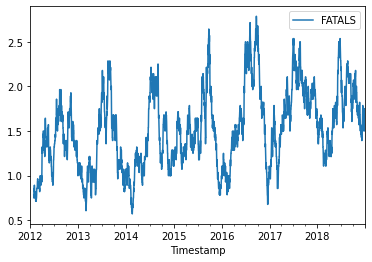

In [13]:
co_daily_fatalities.rolling(28).mean().plot()

Make a pivot table with "DAY_WEEK" as columns, "HOUR" as index, "FATALS" as values, and 'sum' as an aggfunc. Visualize as a heatmap. Sunday is 1 and Saturday is 7.

<AxesSubplot:ylabel='HOUR'>

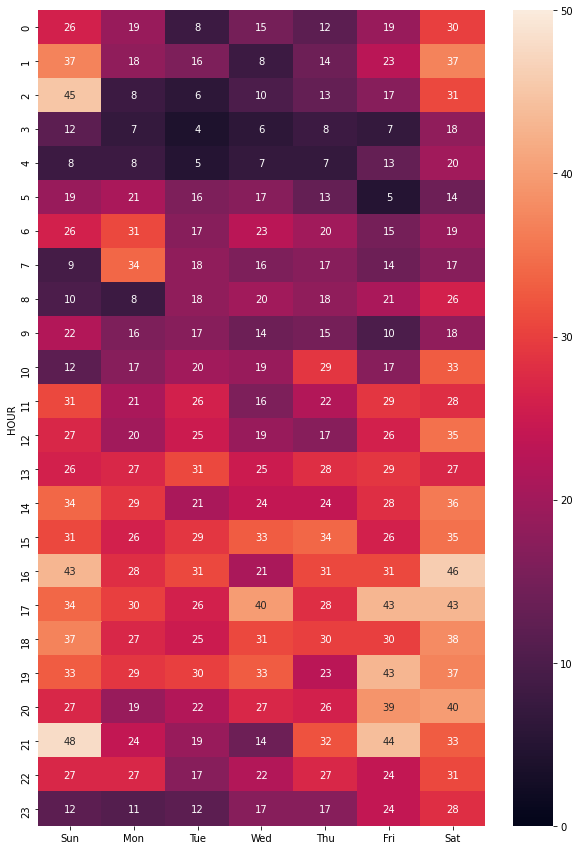

In [17]:
co_pivot_df = pd.pivot_table(co_fars_gdf,
                             index='HOUR',
                             columns='DAY_WEEK',
                             values='FATALS',
                             aggfunc='sum'
                            )

co_pivot_df.columns = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']

f,ax = plt.subplots(figsize=(10,15))
sb.heatmap(co_pivot_df,ax=ax,annot=True,vmin=0,vmax=50)

## Point plot

Visualize the individual incidents.

<AxesSubplot:>

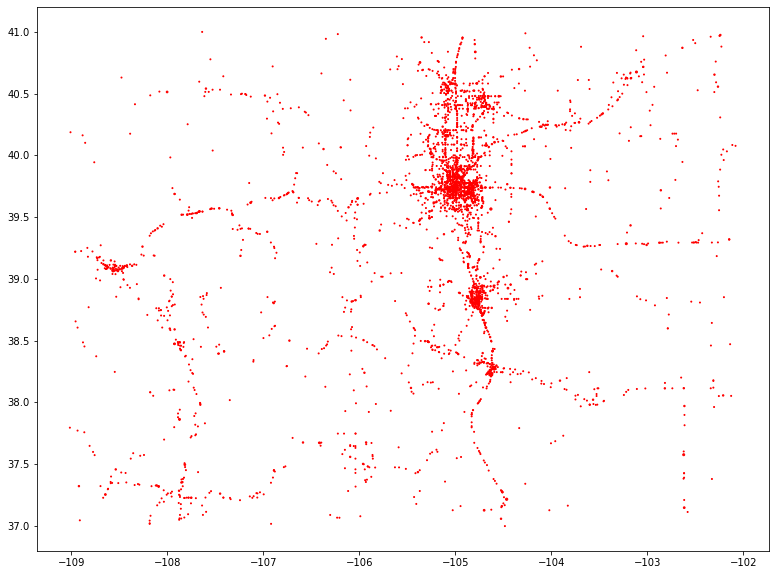

In [18]:
f,ax = plt.subplots(figsize=(15,10))

co_fars_gdf.plot(ax=ax,markersize='FATALS',color='r')

Visualize using the Colorado state boundaries.

<AxesSubplot:>

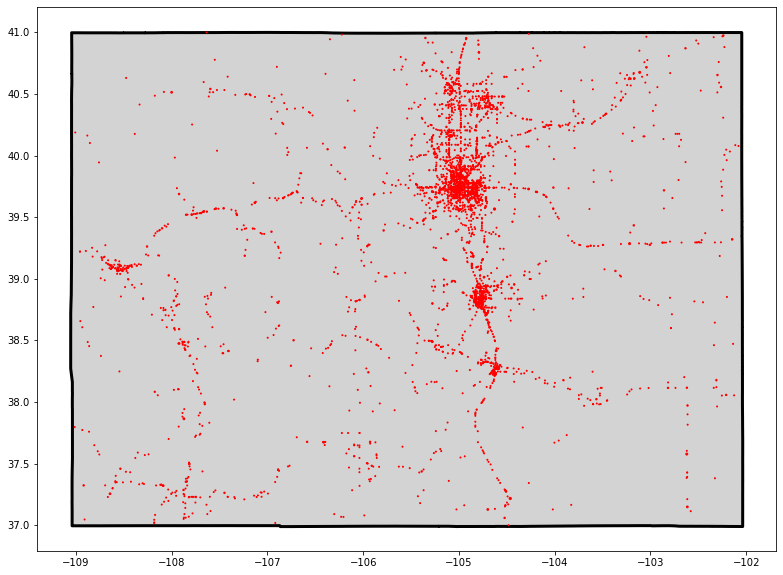

In [19]:
co_state_gdf = states_gdf[states_gdf['NAME']=='Colorado']

f,ax = plt.subplots(figsize=(15,10))
co_fars_gdf.plot(ax=ax,markersize='FATALS',color='r')
co_state_gdf.plot(ax=ax,color='lightgrey',edgecolor='k',lw=3,zorder=0)

Visualize using a basemap. You may need to convert to another CRS like [EPSG:3857](https://epsg.io/3857) used by Google, OSM, etc.

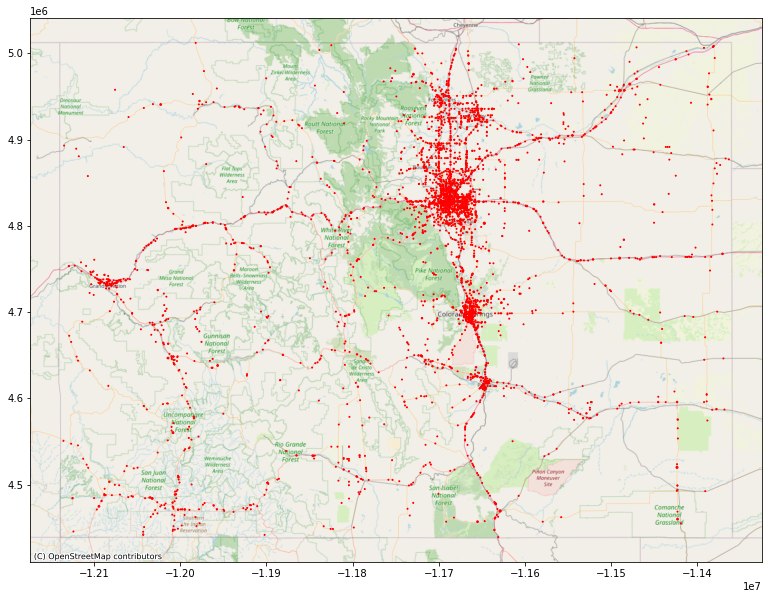

In [20]:
co_fars_3857_gdf = co_fars_gdf.to_crs('EPSG:3857')

f,ax = plt.subplots(figsize=(15,10))

co_fars_3857_gdf.plot(ax=ax,markersize='FATALS',color='r')

contextily.add_basemap(ax,source=contextily.providers.OpenStreetMap.Mapnik)

## Make a density plot

Use geoplot's [`kdeplot`](https://residentmario.github.io/geoplot/plot_references/plot_reference.html#kdeplot) ([tutorial](https://geopandas.org/gallery/plotting_with_geoplot.html)) to make a density plot of these points. Use geoplot's `webmap` to include a basemap.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


<GeoAxesSubplot:>

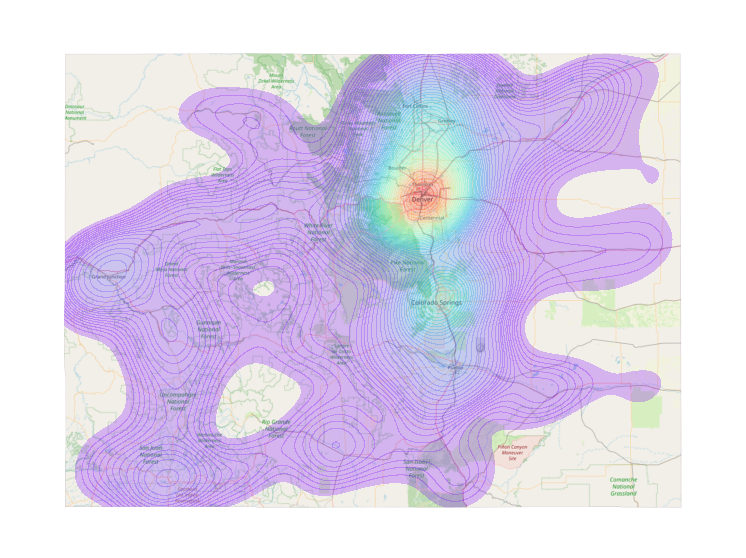

In [21]:
ax = geoplot.kdeplot(df = co_fars_gdf,
                     cmap = 'rainbow',
                     n_levels = 50,
                     shade = True,
                     alpha = .25,
                     projection = geoplot.crs.WebMercator(),
                     figsize = (15,10),
                     clip = co_state_gdf
                    )

geoplot.webmap(df = co_fars_gdf,
               projection = geoplot.crs.WebMercator(),
               provider = contextily.providers.OpenStreetMap.Mapnik,
               ax = ax
              )

## Convert to a choropleth

We have done joins above and before in previous classes, but spatial data presents a new way to join data as well. A [spatial join](https://geopandas.org/mergingdata.html#spatial-joins) combines and merges data based on their respective geometries: is a Point within a Polygon for example? This is valuable if we want to take spatial data like accidents and aggregate to count the number of incidents per county. 

A spatial join allows us to merge the `co_counties_gdf` GeoDataFrame and the `co_fars_gdf` GeoDataFrame. Because the `co_fars_gdf` already has a column for "County" this feels a bit redundant, but because spatial joins are so powerful, I still want to cover how to do them and use the existing labels for verification.

Inspect the `co_counties_gdf`.

In [22]:
co_counties_gdf.head(2)

,co_fips,county,househo_20,pop_2010,shape_st_1,shape_st_2,shape_star,shape_stle,geometry
0,1.0,Adams,154502.0,441603.0,3.064413e+09,392729.110497,0.0,0.0,"POLYGON ((-103.70574 39.99991, -103.70569 39.9..."
1,3.0,Alamosa,6008.0,15445.0,1.872295e+09,177555.351470,0.0,0.0,"POLYGON ((-105.59917 37.75216, -105.51619 37.7..."


Inspect the `co_fars_gdf`.

In [23]:
co_fars_gdf.head(2)

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,NHS,ROAD_FNC,ROUTE,TWAY_ID,TWAY_ID2,MILEPT,LATITUDE,LONGITUD,SP_JUR,HARM_EV,MAN_COLL,RELJCT1,RELJCT2,TYP_INT,WRK_ZONE,REL_ROAD,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS,RAIL,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR,RUR_URB,FUNC_SYS,RD_OWNER,State,County,Timestamp,geometry
4838,8,80001,1,1,0,1,1,1,1,97,0,1,1,2012,1,2,25,1,13.0,3,SR-82,NaN,382,39.211931,-106.861803,0,8,0,0,1,1,0,1,2,1,0,1,0,0000000,99,99,99,99,88,88,0,0,0,1,0,NaN,NaN,NaN,Colorado,Pitkin,2012-01-01 02:25:00,POINT (-106.86180 39.21193)
4839,8,80002,2,2,0,0,0,2,2,75,0,4,1,2012,4,7,36,0,6.0,4,CR-32,CR-35.7,0,40.653789,-103.244814,0,12,6,0,2,2,0,1,1,1,0,1,0,0000000,7,36,99,99,99,99,0,0,0,1,0,NaN,NaN,NaN,Colorado,Logan,2012-01-04 07:36:00,POINT (-103.24481 40.65379)


Do the `sjoin` with `co_fars_gdf` on the left, `co_counties_gdf` on the right, using a "left" join, and an "intersects" operation.

In [24]:
fars_county_sjoin_gdf = gpd.sjoin(left_df = co_fars_gdf,
                                  right_df = co_counties_gdf,
                                  how = 'left',
                                  op = 'intersects'
                                 )

fars_county_sjoin_gdf.head()

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,NHS,ROAD_FNC,ROUTE,TWAY_ID,TWAY_ID2,MILEPT,LATITUDE,LONGITUD,SP_JUR,HARM_EV,MAN_COLL,RELJCT1,RELJCT2,TYP_INT,WRK_ZONE,REL_ROAD,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS,RAIL,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR,RUR_URB,FUNC_SYS,RD_OWNER,State,County,Timestamp,geometry,index_right,co_fips,county,househo_20,pop_2010,shape_st_1,shape_st_2,shape_star,shape_stle
4838,8,80001,1,1,0,1,1,1,1,97,0,1,1,2012,1,2,25,1,13.0,3,SR-82,NaN,382,39.211931,-106.861803,0,8,0,0,1,1,0,1,2,1,0,1,0,0000000,99,99,99,99,88,88,0,0,0,1,0,NaN,NaN,NaN,Colorado,Pitkin,2012-01-01 02:25:00,POINT (-106.86180 39.21193),26,97.0,Pitkin,8156.0,17148.0,2.514621e+09,276458.628942,0.0,0.0
4839,8,80002,2,2,0,0,0,2,2,75,0,4,1,2012,4,7,36,0,6.0,4,CR-32,CR-35.7,0,40.653789,-103.244814,0,12,6,0,2,2,0,1,1,1,0,1,0,0000000,7,36,99,99,99,99,0,0,0,1,0,NaN,NaN,NaN,Colorado,Logan,2012-01-04 07:36:00,POINT (-103.24481 40.65379),14,75.0,Logan,8053.0,22709.0,4.775983e+09,282085.505972,0.0,0.0
4840,8,80003,1,1,0,0,0,1,1,93,0,4,1,2012,4,20,45,0,4.0,4,CR-43,NaN,49,39.487464,-105.501722,0,1,0,0,1,1,0,4,2,1,0,1,0,0000000,99,99,99,99,88,88,0,0,0,1,1,NaN,NaN,NaN,Colorado,Park,2012-01-04 20:45:00,POINT (-105.50172 39.48746),56,93.0,Park,7199.0,16206.0,5.721119e+09,369348.223536,0.0,0.0
4841,8,80005,1,1,0,0,0,1,1,125,0,6,1,2012,6,15,20,0,6.0,4,CR-PP,NaN,0,40.084214,-102.113906,0,10,0,0,6,1,0,1,1,1,0,1,0,057349H,15,29,16,25,88,88,0,0,0,1,0,NaN,NaN,NaN,Colorado,Yuma,2012-01-06 15:20:00,POINT (-102.11391 40.08421),63,125.0,Yuma,3947.0,10043.0,6.137023e+09,321423.270613,0.0,0.0
4842,8,80006,1,1,0,0,0,1,1,5,110,7,1,2012,7,1,37,1,13.0,2,US-40 E COLFAX AVE,N XANADU ST,3060,39.740108,-104.831406,0,46,0,0,3,2,0,4,3,1,0,1,0,0000000,1,37,1,42,88,88,0,0,0,1,1,NaN,NaN,NaN,Colorado,Arapahoe,2012-01-07 01:37:00,POINT (-104.83141 39.74011),2,5.0,Arapahoe,225124.0,572003.0,2.084863e+09,335003.471310,0.0,0.0


Compare.

In [25]:
mismatched_counties = fars_county_sjoin_gdf['County'] != fars_county_sjoin_gdf['county']

fars_mismatched_gdf = fars_county_sjoin_gdf[mismatched_counties]
print(fars_mismatched_gdf.shape)

fars_mismatched_gdf[['County','county']]

(22, 66)


,County,county
4859,El Paso,Douglas
5058,Denver,Jefferson
5241,Denver,Arapahoe
35993,Denver,Arapahoe
36331,Broomfield,Adams
66159,Arapahoe,Adams
66363,Weld,Adams
66389,Weld,Adams
66393,Arapahoe,Denver
130234,Arapahoe,Denver


Where are these errors? They all appear to be on county boundary lines/roads.

<AxesSubplot:>

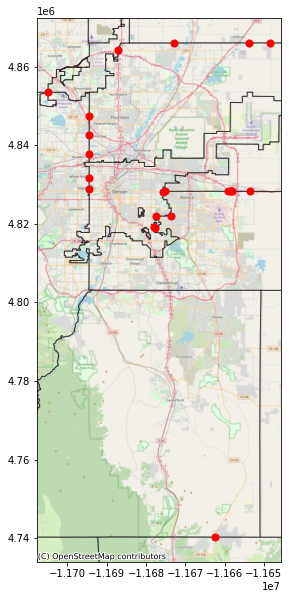

In [26]:
co_fars_mismatched_3857_gdf = fars_mismatched_gdf.to_crs('EPSG:3857')
co_counties_3857_gdf = co_counties_gdf.to_crs('EPSG:3857')

f,ax = plt.subplots(figsize=(15,10))

# https://stackoverflow.com/a/28198278/1574687
# ax.xaxis.set_major_formatter(plt.NullFormatter())

co_fars_mismatched_3857_gdf.plot(ax=ax,markersize=50,color='r',zorder=2)
contextily.add_basemap(ax,source=contextily.providers.OpenStreetMap.Mapnik)
co_counties_3857_gdf.plot(ax=ax,facecolor='none',edgecolor='k',alpha=.5)

Group total fatalities by county and merge back into `co_counties_gdf`.

In [27]:
county_fatalities_df = fars_county_sjoin_gdf.groupby(['county']).agg({"FATALS":'sum'})

co_counties_fars_gdf = pd.merge(left = co_counties_gdf,
                       right = county_fatalities_df,
                       how = 'left',
                       left_on = 'county',
                       right_index = True
                      )

co_counties_fars_gdf.head()

,co_fips,county,househo_20,pop_2010,shape_st_1,shape_st_2,shape_star,shape_stle,geometry,FATALS
0,1.0,Adams,154502.0,441603.0,3.064413e+09,392729.110497,0.0,0.0,"POLYGON ((-103.70574 39.99991, -103.70569 39.9...",320
1,3.0,Alamosa,6008.0,15445.0,1.872295e+09,177555.351470,0.0,0.0,"POLYGON ((-105.59917 37.75216, -105.51619 37.7...",24
2,5.0,Arapahoe,225124.0,572003.0,2.084863e+09,335003.471310,0.0,0.0,"MULTIPOLYGON (((-103.70653 39.73986, -103.7066...",247
3,7.0,Archuleta,5257.0,12084.0,3.504795e+09,263558.683443,0.0,0.0,"POLYGON ((-107.12854 37.42287, -107.12881 37.3...",18
4,11.0,Bent,1835.0,6499.0,3.990976e+09,254662.200852,0.0,0.0,"POLYGON ((-102.74208 38.26675, -102.74211 38.2...",8


Visualize county-level data as a choropleth.

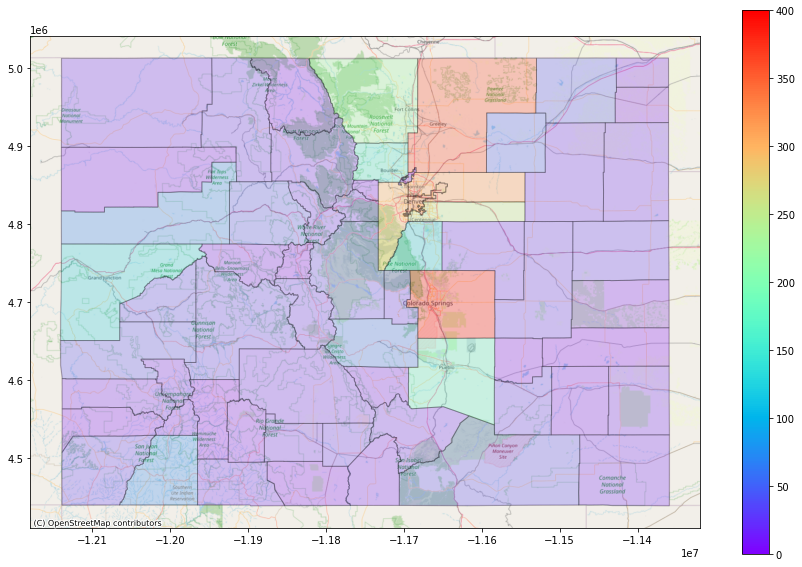

In [28]:
co_counties_3857_fars_gdf = co_counties_fars_gdf.to_crs('EPSG:3857')

f,ax = plt.subplots(figsize=(15,10))

co_counties_3857_fars_gdf.plot(column = 'FATALS',
                               cmap = 'rainbow',
                               legend = True,
                               vmin = 0,
                               vmax = 400,
                               edgecolor = 'k',
                               alpha = .25,
                               ax=ax)

contextily.add_basemap(ax,source=contextily.providers.OpenStreetMap.Mapnik)

## Appendix

Read in the files and concatenate together.

In [ ]:
fars_accident_l = []

for y in range(2012,2019):
    _df = pd.read_csv('fars_{0}_accident.csv'.format(y))
    fars_accident_l.append(_df)
    
fars_accident_df = pd.concat(fars_accident_l,ignore_index=True)
fars_accident_df.head()

Get the GSA [Geographic Locator Codes](https://www.gsa.gov/reference/geographic-locator-codes-glcs-overview) for the states and counties used in the FARS data. These are at City-level, so make a DataFrame of just State and County codes.

In [ ]:
glc_df = pd.read_excel('https://www.gsa.gov/cdnstatic/FRPP_GLC_-_United_StatesSep292020.xlsx')

# Make title-cased
glc_df['State Name'] = glc_df['State Name'].str.title()
glc_df['City Name'] = glc_df['City Name'].str.title()
glc_df['County Name'] = glc_df['County Name'].str.title()

# Groupby state and county
glc_state_county = glc_df.groupby(['State Code','County Code']).agg({'State Name':'first','County Name':'first'}).reset_index()


Merge in state and county codes with the FARS data.

In [ ]:
labeled_fars_df = pd.merge(left = fars_accident_df,
         right = glc_state_county,
         how = 'left',
         left_on = ['STATE','COUNTY'],
         right_on = ['State Code','County Code']
        )

labeled_fars_df.drop(columns=['timestamp','geometry','State Code','County Code'],inplace=True)

labeled_fars_df.to_csv('fars_2012-2018.csv',index=False)

labeled_fars_df.head()